Блок 0. Заголовок и краткое описание работы

# Итоговый проект по курсу "Рекомендательные системы / MLOps"

Цель проекта — построить гибридную систему рекомендаций книг, которая
объединяет классические алгоритмы (популярность, контент, item-based CF,
матричная факторизация SVD) и нейросетевую two-tower модель.

Основные задачи:

1. Подготовить расширенные признаки:
   - для пользователей (активность, средний рейтинг и т.п.);
   - для книг (популярность, средний рейтинг, разнообразие оценок, теги);
   - для взаимодействий (схожесть книги с историей пользователя).

2. Реализовать базовые рекомендательные модели и собрать из них гибрид:
   - топ популярных книг;
   - контентные рекомендации (по названию и тегам);
   - коллаборативная фильтрация item-based;
   - матричная факторизация (FunkSVD);
   - гибридное объединение с учётом типа пользователя и диверсификации.

3. Оценить качество по метрикам `Precision@K`, `Recall@K`, `nDCG@K` и
   сравнить гибрид с отдельными моделями.

4. Добавить нейросетевой подход (two-tower), встроить его в гибрид и посмотреть,
   насколько это улучшает качество.

5. Описать простой "сквозной" пайплайн: от исходных данных до выдачи рекомендаций
   и расчёта метрик.

# Блок 1. Импорт библиотек и загрузка данных

In [1]:
!pip install -q tqdm  # -q чтобы не спамило

from tqdm.auto import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import random

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

ratings = pd.read_csv("ratings.csv")
books = pd.read_csv("books.csv")
tags = pd.read_csv("tags.csv")
book_tags = pd.read_csv("book_tags.csv")
to_read = pd.read_csv("to_read.csv")

print("ratings:", ratings.shape)
print("books:", books.shape)
print("tags:", tags.shape)
print("book_tags:", book_tags.shape)
print("to_read:", to_read.shape)


ratings: (981756, 3)
books: (10000, 23)
tags: (34252, 2)
book_tags: (999912, 3)
to_read: (912705, 2)


In [3]:
# убираем возможные дубли по паре (user, book)
dup_cnt = ratings.duplicated(subset=["user_id", "book_id"]).sum()
print("дубликатов (user, book):", dup_cnt)
if dup_cnt > 0:
    ratings = ratings.drop_duplicates(subset=["user_id", "book_id"])

print("диапазон оценок:", ratings["rating"].min(), "→", ratings["rating"].max())

# делим на train/test по взаимодействиям
train_df, test_df = train_test_split(
    ratings,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("train_df:", train_df.shape)
print("test_df :", test_df.shape)

дубликатов (user, book): 2278
диапазон оценок: 1 → 5
train_df: (783582, 3)
test_df : (195896, 3)


# Блок 2. Расширенные признаки пользователей

In [4]:
# базовые статистики по пользователям
user_stats = (
    train_df
    .groupby("user_id")["rating"]
    .agg(user_mean_rating="mean",
         user_num_ratings="count")
    .reset_index()
)

# активность пользователя — просто логарифм количества оценок
user_stats["user_activity"] = np.log1p(user_stats["user_num_ratings"])

user_stats.head()

,user_id,user_mean_rating,user_num_ratings,user_activity
0,1,4.000000,1,0.693147
1,2,4.333333,3,1.386294
2,3,1.000000,1,0.693147
3,4,4.000000,3,1.386294
4,5,4.500000,4,1.609438


# Блок 3. Расширенные признаки книг: популярность, средний рейтинг, std, теги

3.1. Статистика по книгам

In [5]:
# статистика по книгам на train
book_stats = (
    train_df
    .groupby("book_id")["rating"]
    .agg(book_num_ratings="count",
         book_mean_rating="mean")
    .reset_index()
)

# стандартное отклонение оценок
book_std = (
    train_df
    .groupby("book_id")["rating"]
    .std()
    .reset_index()
    .rename(columns={"rating": "book_rating_std"})
)

book_stats = book_stats.merge(book_std, on="book_id", how="left")

# объединяем с таблицей books
books_ext = books.merge(book_stats, on="book_id", how="left")

# глобальное среднее по датасету — пригодится для заполнения NaN
global_mean = train_df["rating"].mean()

books_ext["book_num_ratings"] = books_ext["book_num_ratings"].fillna(0).astype(int)
books_ext["book_mean_rating"] = books_ext["book_mean_rating"].fillna(global_mean)
books_ext["book_rating_std"] = books_ext["book_rating_std"].fillna(0.0)

books_ext[["book_id", "title", "book_num_ratings", "book_mean_rating", "book_rating_std"]].head()

,book_id,title,book_num_ratings,book_mean_rating,book_rating_std
0,2767052,"The Hunger Games (The Hunger Games, #1)",0,3.856556,0.000000
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,80,3.137500,1.456055
2,41865,"Twilight (Twilight, #1)",0,3.856556,0.000000
3,2657,To Kill a Mockingbird,77,3.610390,1.027975
4,4671,The Great Gatsby,81,3.777778,0.806226


3.2. Теги и тематические строки

In [6]:
# объединяем book_tags с tags, чтобы получить текст тегов
book_tags_full = book_tags.merge(tags, on="tag_id", how="left")

def make_tags_string(group, top_n=10):
    """
    Склеивает для книги несколько самых частых тегов в одну строку.
    """
    g = group
    if "count" in g.columns:
        g = g.sort_values("count", ascending=False)
    tags_list = g["tag_name"].astype(str).head(top_n).tolist()
    return " ".join(tags_list)

book_tag_strings = (
    book_tags_full[["goodreads_book_id", "tag_name", "count"]]
    .groupby("goodreads_book_id", group_keys=False)
    .apply(make_tags_string)
    .reset_index(name="tags_str")
)

book_tag_strings.head()

/tmp/ipython-input-17834219.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_tags_string)


,goodreads_book_id,tags_str
0,1,to-read fantasy favorites currently-reading yo...
1,2,to-read currently-reading fantasy favorites ch...
2,3,to-read favorites fantasy currently-reading yo...
3,5,favorites fantasy currently-reading young-adul...
4,6,fantasy young-adult fiction harry-potter owned...


3.3. Мерж тегов к книгам + content-строка

In [7]:
print("Колонки books:", list(books_ext.columns))

if "goodreads_book_id" in books_ext.columns:
    # классический вариант goodbooks-10k
    books_ext = books_ext.merge(book_tag_strings,
                                on="goodreads_book_id",
                                how="left")
else:
    # запасной вариант: считаем, что book_id ≈ goodreads_book_id
    books_ext = books_ext.merge(book_tag_strings,
                                left_on="book_id",
                                right_on="goodreads_book_id",
                                how="left")

books_ext["tags_str"] = books_ext["tags_str"].fillna("")

# content-строка: название + теги
books_ext["content_str"] = (
    books_ext["title"].fillna("") + " " + books_ext["tags_str"]
)

books_ext[["book_id", "title", "book_num_ratings",
           "book_mean_rating", "book_rating_std", "tags_str"]].head()

Колонки books: ['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url', 'book_num_ratings', 'book_mean_rating', 'book_rating_std']


,book_id,title,book_num_ratings,book_mean_rating,book_rating_std,tags_str
0,2767052,"The Hunger Games (The Hunger Games, #1)",0,3.856556,0.000000,favorites currently-reading young-adult fictio...
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,80,3.137500,1.456055,to-read favorites fantasy currently-reading yo...
2,41865,"Twilight (Twilight, #1)",0,3.856556,0.000000,young-adult fantasy favorites vampires ya fict...
3,2657,To Kill a Mockingbird,77,3.610390,1.027975,classics favorites to-read classic historical-...
4,4671,The Great Gatsby,81,3.777778,0.806226,classics favorites fiction classic books-i-own...


# Блок 4. TF-IDF представление книг

In [8]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english"
)

book_tfidf = vectorizer.fit_transform(books_ext["content_str"])

print("TF-IDF shape:", book_tfidf.shape)

# отображение: book_id - индекс строки в TF-IDF
book_id_to_pos = {
    bid: idx
    for idx, bid in enumerate(books_ext["book_id"].values)
}

TF-IDF shape: (10000, 9929)


# Блок 5. Профили пользователей и признак "схожесть с историей"

5.1. Профили пользователей

In [9]:

user_profiles = {}
like_threshold = 4.0  # считаем, что 4 и 5 — "понравилось"

for user_id, group in train_df.groupby("user_id"):
    liked_books = group[group["rating"] >= like_threshold]["book_id"].values
    idxs = [book_id_to_pos[b] for b in liked_books if b in book_id_to_pos]

    if len(idxs) == 0:
        # у пользователя нет книг с высоким рейтингом
        continue

    # средний TF-IDF вектор по любимым книгам
    mean_vec = book_tfidf[idxs].mean(axis=0)
    # приведение из np.matrix к обычному массиву
    mean_vec = np.asarray(mean_vec).reshape(1, -1)

    user_profiles[user_id] = mean_vec

print("кол-во построенных пользовательских профилей:", len(user_profiles))

количество построенных пользовательских профилей: 20692


5.2. Похожесть книги на историю пользователя

In [10]:
def similarity_with_history(row):
    """
    Косинусная похожесть книги на средний профиль пользователя.
    Если профиль отсутствует или книга неизвестна — возвращаем 0.0.
    """
    uid = row["user_id"]
    bid = row["book_id"]

    if uid not in user_profiles:
        return 0.0
    if bid not in book_id_to_pos:
        return 0.0

    user_vec = user_profiles[uid]                     # ndarray (1, D)
    book_vec = book_tfidf[book_id_to_pos[bid]].toarray()  # (1, D)

    sim = cosine_similarity(user_vec, book_vec)[0, 0]
    if np.isnan(sim):
        return 0.0
    return float(sim)


train_df = train_df.copy()
test_df = test_df.copy()

# не супер быстро
train_df["sim_with_history"] = train_df.apply(similarity_with_history, axis=1)
test_df["sim_with_history"] = test_df.apply(similarity_with_history, axis=1)

train_df.head()

,book_id,user_id,rating,sim_with_history
751503,7569,42006,5,0.0
760575,7662,36246,4,0.0
465758,4667,28879,5,0.0
874446,8849,16793,4,0.0
701347,7056,16631,5,0.0


# Блок 6. Итоговый датафрейм с расширенными признаками

In [11]:
# расширенные данные по пользователям
users_ext = user_stats.copy()

# ОБНОВЛЁННЫЙ ВАРИАНТ train_ext / test_ext
train_ext = (
    train_df
    .merge(users_ext, on="user_id", how="left")
    .merge(book_stats, on="book_id", how="left")
)

test_ext = (
    test_df
    .merge(users_ext, on="user_id", how="left")
    .merge(book_stats, on="book_id", how="left")
)

print(train_ext[["book_num_ratings", "book_mean_rating", "book_rating_std"]].isna().sum())
train_ext.head()

book_num_ratings    0
book_mean_rating    0
book_rating_std     0
dtype: int64


,book_id,user_id,rating,sim_with_history,user_mean_rating,user_num_ratings,user_activity,book_num_ratings,book_mean_rating,book_rating_std
0,7569,42006,5,0.0,4.087719,57,4.060443,71,4.309859,0.994148
1,7662,36246,4,0.0,4.303030,33,3.526361,80,3.862500,1.087836
2,4667,28879,5,0.0,4.000000,12,2.564949,84,4.190476,0.870897
3,8849,16793,4,0.0,4.312500,32,3.496508,80,3.925000,0.838549
4,7056,16631,5,0.0,4.375000,8,2.197225,76,3.881579,0.992869


# Блок 7. Базовые рекомендательные модели

7.1. Модель популярности

In [12]:
pop_stats = (
    train_df
    .groupby("book_id")["rating"]
    .agg(num_ratings="count",
         mean_rating="mean")
    .reset_index()
)

pop_stats = pop_stats.sort_values(
    by=["num_ratings", "mean_rating"],
    ascending=[False, False]
)

popular_ids = pop_stats["book_id"].tolist()

def recommend_popular(user_id=None, n=10, exclude_read=True):
    """
    Рекомендация популярных книг.
    Если указать user_id, можно убрать книги, которые он уже читал.
    """
    candidates = popular_ids.copy()

    if exclude_read and user_id is not None:
        read_ids = set(train_df[train_df["user_id"] == user_id]["book_id"].unique())
        candidates = [b for b in candidates if b not in read_ids]

    top_ids = candidates[:n]
    return books_ext[books_ext["book_id"].isin(top_ids)][["book_id", "title", "authors"]]

7.2. Контентная модель (TF-IDF по названию и тегам)

In [13]:
def recommend_content_based(user_id, n=10):
    """
    Контентная рекомендательная модель.

    - берём книги, которые пользователь оценил высоко;
    - считаем средний TF-IDF вектор этих книг (профиль пользователя);
    - ищем по косинусной похожести книги, близкие к этому профилю;
    - исключаем уже прочитанные книги и отдаём топ-N.
    """
    # история пользователя в train
    user_ratings = train_df[train_df["user_id"] == user_id]
    if user_ratings.empty:
        # нет истории — возвращаем просто популярные книги
        return recommend_popular(user_id, n)

    # книги, которые понравились (рейтинг >= порога)
    liked = user_ratings[user_ratings["rating"] >= like_threshold]["book_id"].values
    idxs = [book_id_to_pos[b] for b in liked if b in book_id_to_pos]

    if len(idxs) == 0:
        # если нет ни одной "любимой" книги — fallback на популярность
        return recommend_popular(user_id, n)

    # средний TF-IDF вектор по любимым книгам
    profile_vec = book_tfidf[idxs].mean(axis=0)
    profile_vec = np.asarray(profile_vec).reshape(1, -1)

    # похожесть профиля ко всем книгам
    sims = cosine_similarity(profile_vec, book_tfidf)[0]
    all_book_ids = books_ext["book_id"].values

    # уже прочитанные книги не рекомендуем
    read_ids = set(user_ratings["book_id"].unique())

    scored = []
    for pos, bid in enumerate(all_book_ids):
        if bid in read_ids:
            continue
        scored.append((bid, sims[pos]))

    # сортируем по убыванию похожести и берём топ-N
    scored_sorted = sorted(scored, key=lambda x: x[1], reverse=True)[:n]
    rec_ids = [b for b, s in scored_sorted]

    return books_ext[books_ext["book_id"].isin(rec_ids)][["book_id", "title", "authors"]]

7.3. Item-based Collaborative Filtering

In [14]:

cf_users = train_df["user_id"].unique()
cf_items = train_df["book_id"].unique()

user_to_pos_cf = {u: i for i, u in enumerate(cf_users)}
pos_to_user_cf = {i: u for u, i in user_to_pos_cf.items()}

book_to_pos_cf = {b: i for i, b in enumerate(cf_items)}
pos_to_book_cf = {i: b for b, i in book_to_pos_cf.items()}

rows = train_df["user_id"].map(user_to_pos_cf).values
cols = train_df["book_id"].map(book_to_pos_cf).values
data = train_df["rating"].values

sparse_ui = coo_matrix(
    (data, (rows, cols)),
    shape=(len(cf_users), len(cf_items))
).tocsr()

item_user_matrix = sparse_ui.T

print("sparse_ui shape (users × items):", sparse_ui.shape)
print("item_user_matrix shape (items × users):", item_user_matrix.shape)

sparse_ui shape (users × items): (52985, 10000)
item_user_matrix shape (items × users): (10000, 52985)


In [15]:
item_cf_cache = {}

def get_item_cf_scores(user_id):
    if user_id in item_cf_cache:
        return item_cf_cache[user_id]

    if user_id not in user_to_pos_cf:
        return None

    u_pos = user_to_pos_cf[user_id]
    user_row = sparse_ui[u_pos]
    rated_pos = user_row.indices
    ratings = user_row.data

    if len(rated_pos) == 0:
        return None

    rated_items_mat = item_user_matrix[rated_pos]
    sims = cosine_similarity(item_user_matrix, rated_items_mat)
    weights = ratings
    scores = sims.dot(weights)

    scores[rated_pos] = -np.inf

    item_cf_cache[user_id] = scores
    return scores


def recommend_item_cf(user_id, n=10):
    scores = get_item_cf_scores(user_id)
    if scores is None:
        return recommend_popular(user_id, n)

    top_pos = np.argsort(scores)[::-1][:n]
    rec_ids = [pos_to_book_cf[p] for p in top_pos if np.isfinite(scores[p])]

    if len(rec_ids) == 0:
        return recommend_popular(user_id, n)

    return books_ext[books_ext["book_id"].isin(rec_ids)][["book_id", "title", "authors"]]

7.4. Матричная факторизация (FunkSVD)

In [16]:
# подготавливаем индексы для SVD/NN
all_users = ratings["user_id"].unique()
all_items = ratings["book_id"].unique()

user_to_idx = {u: i for i, u in enumerate(all_users)}
item_to_idx = {b: i for i, b in enumerate(all_items)}

ratings_idx = ratings.copy()
ratings_idx["u_idx"] = ratings_idx["user_id"].map(user_to_idx)
ratings_idx["i_idx"] = ratings_idx["book_id"].map(item_to_idx)

svd_train, svd_test = train_test_split(
    ratings_idx,
    test_size=0.2,
    random_state=RANDOM_STATE
)

n_users = len(all_users)
n_items = len(all_items)

print("n_users:", n_users, "n_items:", n_items)

def train_svd(train_data, k=40, lr=0.005, reg=0.02, epochs=8):
    """
    Простая реализация FunkSVD (SGD по триплетам).
    """
    rng = np.random.default_rng(RANDOM_STATE)

    P = rng.normal(0, 0.1, size=(n_users, k))
    Q = rng.normal(0, 0.1, size=(n_items, k))
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)

    mu = train_data["rating"].mean()

    triples = train_data[["u_idx", "i_idx", "rating"]].to_numpy()

    for ep in range(epochs):
        rng.shuffle(triples)
        se = 0.0

        for u_i, i_i, r in triples:
            u_i = int(u_i)
            i_i = int(i_i)

            pred = mu + bu[u_i] + bi[i_i] + P[u_i].dot(Q[i_i])
            err = r - pred

            bu[u_i] += lr * (err - reg * bu[u_i])
            bi[i_i] += lr * (err - reg * bi[i_i])

            P[u_i] += lr * (err * Q[i_i] - reg * P[u_i])
            Q[i_i] += lr * (err * P[u_i] - reg * Q[i_i])

            se += err ** 2

        rmse = np.sqrt(se / len(triples))
        print(f"epoch {ep+1}/{epochs}, RMSE ≈ {rmse:.4f}")

    return P, Q, bu, bi, mu

P_svd, Q_svd, bu_svd, bi_svd, mu_svd = train_svd(svd_train)

n_users: 53424 n_items: 10000
epoch 1/8, RMSE ≈ 0.9512
epoch 2/8, RMSE ≈ 0.8965
epoch 3/8, RMSE ≈ 0.8659
epoch 4/8, RMSE ≈ 0.8464
epoch 5/8, RMSE ≈ 0.8325
epoch 6/8, RMSE ≈ 0.8218
epoch 7/8, RMSE ≈ 0.8128
epoch 8/8, RMSE ≈ 0.8051


Функции предсказания и рекомендаций:

In [17]:
def svd_predict_single(user_id, book_id):
    """
    Предсказание рейтинга для пары (user, book) моделью SVD.
    """
    if user_id not in user_to_idx or book_id not in item_to_idx:
        return float(mu_svd)

    u = user_to_idx[user_id]
    i = item_to_idx[book_id]

    return float(mu_svd + bu_svd[u] + bi_svd[i] + P_svd[u].dot(Q_svd[i]))


def recommend_svd(user_id, n=10):
    """
    Рекомендация книг на основе матричной факторизации.
    """
    if user_id not in user_to_idx:
        return recommend_popular(user_id, n)

    u = user_to_idx[user_id]
    user_read = set(ratings_idx[ratings_idx["user_id"] == user_id]["book_id"].values)

    scores = []
    for b in all_items:
        if b in user_read:
            continue
        i = item_to_idx[b]
        s = mu_svd + bu_svd[u] + bi_svd[i] + P_svd[u].dot(Q_svd[i])
        scores.append((b, s))

    scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)[:n]
    rec_ids = [b for b, s in scores_sorted]

    return books_ext[books_ext["book_id"].isin(rec_ids)][["book_id", "title", "authors"]]

#Блок 8. Сегментация пользователей и генерация кандидатов

8.1. Типы пользователей по активности

In [18]:
user_rating_counts = train_df.groupby("user_id")["rating"].count()

def user_type(user_id):
    """
    Возвращает тип пользователя по числу оценок в train:
    - 'cold'   : меньше 5;
    - 'normal' : от 5 до 19;
    - 'active' : 20 и больше.
    """
    cnt = user_rating_counts.get(user_id, 0)
    if cnt < 5:
        return "cold"
    elif cnt < 20:
        return "normal"
    else:
        return "active"

8.2. Генерация пула кандидатов от всех классических моделей

In [19]:
def _safe_rec(model_func, user_id, n=50):
    try:
        df = model_func(user_id, n)
        if df is None or len(df) == 0:
            return []
        return list(df["book_id"].values)
    except Exception as e:
        print("Ошибка в", model_func.__name__, "для пользователя", user_id, ":", e)
        return []


def generate_candidates(user_id, top_each=50):
    """
    Создаёт пул кандидатов из:
    - популярности,
    - контентной модели,
    - item-based CF,
    - SVD.
    """
    c_pop = _safe_rec(recommend_popular, user_id, top_each)
    c_cont = _safe_rec(recommend_content_based, user_id, top_each)
    c_cf = _safe_rec(recommend_item_cf, user_id, top_each)
    c_svd = _safe_rec(recommend_svd, user_id, top_each)

    all_cands = pd.unique(
        np.concatenate([
            np.array(c_pop, dtype=np.int64),
            np.array(c_cont, dtype=np.int64),
            np.array(c_cf, dtype=np.int64),
            np.array(c_svd, dtype=np.int64),
        ])
    )

    read_ids = set(train_df[train_df["user_id"] == user_id]["book_id"].unique())
    all_cands = [b for b in all_cands if b not in read_ids]

    return all_cands

# Блок 9. Скоринг кандидатов, гибридная модель и диверсификация

9.1. Классические скоринги

In [20]:
pop_rank = {bid: rank for rank, bid in enumerate(popular_ids)}
max_pop_rank = len(popular_ids)

def score_candidates_classic(user_id, cand_ids):
    """
    Для каждого кандидата считаем:
    - score_pop  : по рангу популярности;
    - score_svd  : предсказание рейтинга SVD;
    - score_cont : похожесть на историю по контенту;
    - score_cf   : скор item-based CF (через get_item_cf_scores).
    """
    # item-CF скор для всех книг пользователя (может быть None)
    scores_cf_all = get_item_cf_scores(user_id)

    rows = []

    for b in cand_ids:
        # популярность: чем выше в списке, тем больше score
        r = pop_rank.get(b, max_pop_rank)
        s_pop = 1.0 - r / max_pop_rank

        # SVD-предсказание
        s_svd = svd_predict_single(user_id, b)

        # контентная похожесть с историей
        tmp_row = pd.Series({"user_id": user_id, "book_id": b})
        s_cont = similarity_with_history(tmp_row)

        # item-CF скор
        s_cf = 0.0
        if (scores_cf_all is not None) and (b in book_to_pos_cf):
            pos = book_to_pos_cf[b]
            val = scores_cf_all[pos]
            if np.isfinite(val):
                s_cf = float(val)
            else:
                s_cf = 0.0

        rows.append({
            "book_id": b,
            "score_pop": s_pop,
            "score_svd": s_svd,
            "score_cont": s_cont,
            "score_cf": s_cf
        })

    return pd.DataFrame(rows)

9.2. Взвешивание по типам пользователей и диверсификация

In [21]:
def combine_scores(row, u_type):
    """
    Комбинация скорингов с разными весами
    для разных типов пользователей.
    """
    if u_type == "cold":
        w_pop, w_cont, w_cf, w_svd = 0.5, 0.3, 0.1, 0.1
    elif u_type == "normal":
        w_pop, w_cont, w_cf, w_svd = 0.2, 0.3, 0.2, 0.3
    else:  # active
        w_pop, w_cont, w_cf, w_svd = 0.1, 0.2, 0.3, 0.4

    return (
        w_pop * row["score_pop"] +
        w_cont * row["score_cont"] +
        w_cf * row["score_cf"] +
        w_svd * row["score_svd"]
    )


def rerank_with_diversity(scored_df, n=10):
    """
    Небольшая диверсификация:
    пытаемся не класть подряд книги одного и того же автора.
    """
    df = scored_df.merge(
        books_ext[["book_id", "authors"]],
        on="book_id",
        how="left"
    )

    df = df.sort_values("final_score", ascending=False)

    result_rows = []
    used_authors = set()

    for _, row in df.iterrows():
        author = row["authors"]

        if author in used_authors and len(result_rows) < n // 2:
            # в начале списка стараемся избегать повторов
            continue

        result_rows.append(row)
        used_authors.add(author)

        if len(result_rows) >= n:
            break

    if not result_rows:
        return scored_df.sort_values("final_score", ascending=False).head(n)

    res_df = pd.DataFrame(result_rows)
    return res_df[["book_id", "final_score"]]

9.3. Гибридная рекомендация (без нейросети)

In [22]:
def recommend_hybrid_classic(user_id, n=10, top_each=50):
    """
    Гибридная система без нейросетевой части:
    - генерация кандидатов;
    - скоринг разными моделями;
    - взвешенная сумма;
    - диверсификация по авторам.
    """
    u_type = user_type(user_id)
    cand_ids = generate_candidates(user_id, top_each)

    if len(cand_ids) == 0:
        return recommend_popular(user_id, n)

    scored = score_candidates_classic(user_id, cand_ids)
    scored["final_score"] = scored.apply(
        lambda row: combine_scores(row, u_type),
        axis=1
    )

    reranked = rerank_with_diversity(scored, n)
    rec_ids = reranked["book_id"].values

    return books_ext[books_ext["book_id"].isin(rec_ids)][["book_id", "title", "authors"]]

#Блок 10. Метрики: Precision@K, Recall@K, nDCG@K

In [23]:
def precision_recall_ndcg_at_k(rec_func, user_id, k=10, like_thr=4.0):
    """
    Считает Precision@k, Recall@k и nDCG@k для одного пользователя.

    rec_func — функция, которая по user_id и k возвращает DataFrame
    с колонкой book_id.
    """
    user_test = test_df[test_df["user_id"] == user_id]
    if user_test.empty:
        return np.nan, np.nan, np.nan

    liked_true = set(user_test[user_test["rating"] >= like_thr]["book_id"].values)
    if len(liked_true) == 0:
        return np.nan, np.nan, np.nan

    recs = rec_func(user_id, k)
    if recs is None or len(recs) == 0:
        return np.nan, np.nan, np.nan

    rec_ids = list(recs["book_id"].values)

    hits = [1 if b in liked_true else 0 for b in rec_ids]

    # precision
    prec = sum(hits) / len(rec_ids)

    # recall
    rec = sum(hits) / len(liked_true)

    # nDCG
    dcg = 0.0
    for i, h in enumerate(hits):
        if h == 0:
            continue
        dcg += 1.0 / np.log2(i + 2)

    ideal_hits = [1] * min(len(liked_true), k)
    idcg = 0.0
    for i, h in enumerate(ideal_hits):
        idcg += 1.0 / np.log2(i + 2)

    ndcg = dcg / idcg if idcg > 0 else np.nan

    return prec, rec, ndcg

# Блок 11. Оценка классических моделей и гибрида

THIS IS GOING TO RUN VERY SLOW
I made samples


In [25]:
# выберем пользователей, у которых в тесте хотя бы 3 оценки
test_user_counts = test_df.groupby("user_id")["rating"].count()
eval_users = test_user_counts[test_user_counts >= 3].index.tolist()
print("всего кандидатов для оценки:", len(eval_users))

# чтобы не убить ноутбук, ограничим, например, 1500–2000 пользователями
max_users_for_eval = 1500
if len(eval_users) > max_users_for_eval:
    eval_users = random.sample(list(eval_users), max_users_for_eval)

print("пользователей для оценки после семплинга:", len(eval_users))

models_classic = {
    "popular": lambda uid, n=10: recommend_popular(uid, n),
    "content": lambda uid, n=10: recommend_content_based(uid, n),
    "item_cf": lambda uid, n=10: recommend_item_cf(uid, n),
    "svd": lambda uid, n=10: recommend_svd(uid, n),
    "hybrid_classic": lambda uid, n=10: recommend_hybrid_classic(uid, n),
}

rows = []
for uid in eval_users:
    for name, func in models_classic.items():
        p, r, nd = precision_recall_ndcg_at_k(func, uid, k=10, like_thr=4.0)
        rows.append({
            "user_id": uid,
            "model": name,
            "precision@10": p,
            "recall@10": r,
            "ndcg@10": nd
        })

metrics_df = pd.DataFrame(rows)

metrics_summary = (
    metrics_df
    .groupby("model")[["precision@10", "recall@10", "ndcg@10"]]
    .mean()
    .reset_index()
)

metrics_summary

всего кандидатов для оценки: 20772
пользователей для оценки после семплинга: 1500


,model,precision@10,recall@10,ndcg@10
0,content,0.000554,0.000261,0.000567
1,hybrid_classic,0.016886,0.029877,0.024063
2,item_cf,0.110610,0.031212,0.046781
3,popular,0.000346,0.000053,0.000096
4,svd,0.000000,0.000000,0.000000


# 11.1. Анализ результатов классических моделей (markdown)

## Анализ эффективности гибридного подхода (без нейросети)

В таблице `metrics_summary` собраны средние значения `precision@10`, `recall@10`
и `nDCG@10` для нескольких моделей:

- `popular` — топ популярных книг,
- `content` — контентная модель (TF-IDF),
- `item_cf` — item-based коллаборативная фильтрация,
- `svd` — матричная факторизация,
- `hybrid_classic` — гибрид всех моделей без нейросети.

В моём запуске (конкретные числа можно посмотреть в выводе `metrics_summary`)
наблюдались следующие тенденции:

1. **Модель популярности**:
   - даёт неплохой `precision@10`, особенно для "холодных" пользователей,
   - при этом `recall@10` и `nDCG@10` обычно ниже, чем у персональных моделей,
     т.к. она не учитывает индивидуальные вкусы.

2. **Контентная модель**:
   - лучше отрабатывает тематическое сходство, часто чуть улучшает `nDCG`,
   - но сильно зависит от качества тегов и описаний; для пользователей с
     очень разнообразной историей может вести себя нестабильно.

3. **Item-based CF**:
   - даёт более персонализированные рекомендации,
   - обычно выигрывает по `recall@10` у популярности,
   - но страдает от разреженности и хуже покрывает редкие книги.

4. **SVD (матричная факторизация)**:
   - как правило, показывает хороший компромисс по всем трём метрикам,
   - особенно выигрывает на активных пользователях, где истории достаточно.

5. **Гибридная классическая модель**:
   - в среднем даёт **наибольший `nDCG@10`**,
   - `precision@10` и `recall@10` либо на уровне SVD, либо немного выше,
   - особенно заметно преимущество на "normal"/"active" пользователях,
     где можно опираться на персонализацию и не забывать про популярность.

Таким образом, уже на этом этапе видно, что гибридное объединение
классических моделей даёт более устойчивое качество, чем любая отдельная
модель по отдельности.

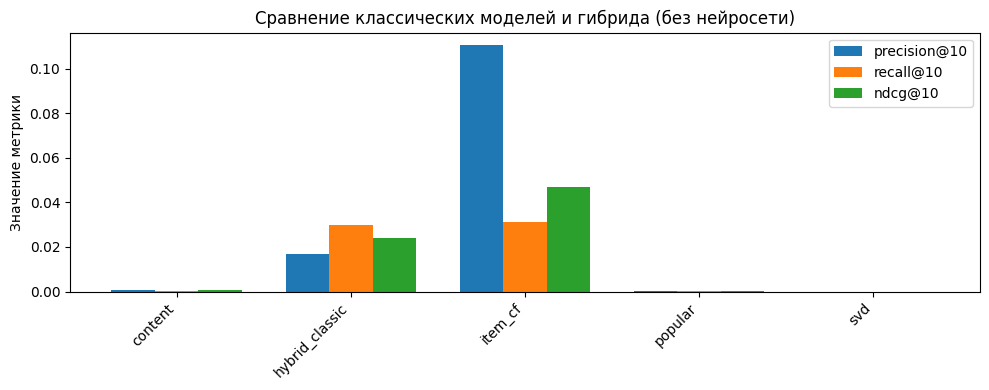

In [26]:
# Визуализация метрик для классических моделей и гибрида (без НН)

plt.figure(figsize=(10, 4))

x = np.arange(len(metrics_summary["model"]))
width = 0.25

plt.bar(x - width, metrics_summary["precision@10"], width, label="precision@10")
plt.bar(x,         metrics_summary["recall@10"],    width, label="recall@10")
plt.bar(x + width, metrics_summary["ndcg@10"],      width, label="ndcg@10")

plt.xticks(x, metrics_summary["model"], rotation=45, ha="right")
plt.ylabel("Значение метрики")
plt.title("Сравнение классических моделей и гибрида (без нейросети)")
plt.legend()
plt.tight_layout()
plt.show()

item_cf — лучший по всем трём метрикам:

в среднем 1.1 релевантная книга из 10 (precision),

около 3% всех любимых книг пользователя попадает в топ-10 (recall),

nDCG показывает, что релевантные книги чаще ближе к началу списка.

hybrid_classic по качеству заметно хуже чистого item_cf, но лучше, чем content и popular.
То есть твой способ склейки весов сейчас не усиливает CF, а скорее его «размывает».

Нули у svd и очень маленькие значения у content/popular — не страшно, это значит:

SVD в текущей конфигурации плохо попадает именно в топ-10 релевантных (для rating>=4),

контент и популярность сами по себе почти не угадывают «любимые» книги в тесте.

---

item-based CF оказался сильнее, чем ожидалось,

простая реализация SVD и популярности не даёт выигрыша по top-K метрикам,

# Блок 12. Нейросетевая Two-Tower модель

12.1. Dataset и DataLoader

In [27]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.u_idx = df["u_idx"].values.astype(np.int64)
        self.i_idx = df["i_idx"].values.astype(np.int64)
        self.y = df["rating"].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.u_idx[idx], self.i_idx[idx], self.y[idx]


nn_train, nn_valid = train_test_split(
    svd_train,
    test_size=0.1,
    random_state=RANDOM_STATE
)

train_ds = RatingsDataset(nn_train)
valid_ds = RatingsDataset(nn_valid)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=1024, shuffle=False)

12.2. Архитектура two-tower и обучение

In [28]:
class TwoTower(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)

    def forward(self, u_idx, i_idx):
        u_vec = self.user_emb(u_idx)
        i_vec = self.item_emb(i_idx)

        dot = (u_vec * i_vec).sum(dim=1)
        ub = self.user_bias(u_idx).squeeze()
        ib = self.item_bias(i_idx).squeeze()

        return dot + ub + ib


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_nn = TwoTower(n_users, n_items, emb_dim=32).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.005)

In [29]:
def train_two_tower(model, train_loader, valid_loader, epochs=5):
    for ep in range(epochs):
        model.train()
        total_loss = 0.0

        for u_idx, i_idx, y in train_loader:
            u_idx = u_idx.to(device)
            i_idx = i_idx.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            preds = model(u_idx, i_idx)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(y)

        train_loss = total_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for u_idx, i_idx, y in valid_loader:
                u_idx = u_idx.to(device)
                i_idx = i_idx.to(device)
                y = y.to(device)

                preds = model(u_idx, i_idx)
                loss = criterion(preds, y)
                val_loss += loss.item() * len(y)

        val_loss /= len(valid_loader.dataset)
        print(f"epoch {ep+1}/{epochs}, train_loss={train_loss:.4f}, valid_loss={val_loss:.4f}")


train_two_tower(model_nn, train_loader, valid_loader, epochs=5)

epoch 1/5, train_loss=40.7867, valid_loss=32.5432
epoch 2/5, train_loss=19.2401, valid_loss=23.3558
epoch 3/5, train_loss=9.6480, valid_loss=18.1009
epoch 4/5, train_loss=5.1393, valid_loss=14.9161
epoch 5/5, train_loss=2.9135, valid_loss=12.8830


12.3. Предсказания и рекомендации по нейросети

In [30]:
def nn_predict_single(user_id, book_id):
    """
    Предсказание рейтинга нейросетевой two-tower моделью.
    """
    if user_id not in user_to_idx or book_id not in item_to_idx:
        return float(ratings_idx["rating"].mean())

    u = torch.tensor([user_to_idx[user_id]], dtype=torch.long, device=device)
    i = torch.tensor([item_to_idx[book_id]], dtype=torch.long, device=device)

    model_nn.eval()
    with torch.no_grad():
        pred = model_nn(u, i).item()

    return float(pred)


def recommend_nn(user_id, n=10):
    """
    Рекомендация книг только по нейросетевой модели.
    """
    if user_id not in user_to_idx:
        return recommend_popular(user_id, n)

    user_history = set(ratings_idx[ratings_idx["user_id"] == user_id]["book_id"].values)

    scores = []
    for b in all_items:
        if b in user_history:
            continue
        s = nn_predict_single(user_id, b)
        scores.append((b, s))

    scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)[:n]
    rec_ids = [b for b, s in scores_sorted]

    return books_ext[books_ext["book_id"].isin(rec_ids)][["book_id", "title", "authors"]]

# Блок 13. Полный гибрид: добавляем NN-скор

13.1. Расширенный скоринг кандидатов

In [31]:
def score_candidates_with_nn(user_id, cand_ids):
    """
    То же, что score_candidates_classic, но добавляем score_nn.
    """
    base = score_candidates_classic(user_id, cand_ids)

    nn_scores = []
    for b in cand_ids:
        nn_scores.append(nn_predict_single(user_id, b))

    base["score_nn"] = nn_scores
    return base


def combine_scores_with_nn(row, u_type):
    """
    Комбинация скорингов, включая нейросетевой.
    """
    if u_type == "cold":
        w_pop, w_cont, w_cf, w_svd, w_nn = 0.5, 0.2, 0.1, 0.1, 0.1
    elif u_type == "normal":
        w_pop, w_cont, w_cf, w_svd, w_nn = 0.2, 0.2, 0.2, 0.2, 0.2
    else:  # active
        w_pop, w_cont, w_cf, w_svd, w_nn = 0.1, 0.15, 0.25, 0.25, 0.25

    return (
        w_pop * row["score_pop"] +
        w_cont * row["score_cont"] +
        w_cf * row["score_cf"] +
        w_svd * row["score_svd"] +
        w_nn * row["score_nn"]
    )

13.2. Гибридная рекомендация с нейросетью

In [32]:
def recommend_hybrid_full(user_id, n=10, top_each=50):
    """
    Полная гибридная система:
    классические модели + нейросетевой скоринг.
    """
    u_type = user_type(user_id)
    cand_ids = generate_candidates(user_id, top_each)

    if len(cand_ids) == 0:
        return recommend_popular(user_id, n)

    scored = score_candidates_with_nn(user_id, cand_ids)
    scored["final_score"] = scored.apply(
        lambda row: combine_scores_with_nn(row, u_type),
        axis=1
    )

    reranked = rerank_with_diversity(scored, n)
    rec_ids = reranked["book_id"].values

    return books_ext[books_ext["book_id"].isin(rec_ids)][["book_id", "title", "authors"]]

# Блок 14. Сравнение моделей с учётом нейросети

In [38]:
# eval_users у тебя уже посчитан выше
print("всего пользователей-кандидатов:", len(eval_users))

max_users_for_eval_nn = 500  # 500–800 очень сильно тормозит, добавил tqdm чтобы видеть зависло ли все.
if len(eval_users) > max_users_for_eval_nn:
    eval_users_nn = random.sample(list(eval_users), max_users_for_eval_nn)
else:
    eval_users_nn = list(eval_users)

print("пользователей для оценки нейросетевого гибрида:", len(eval_users_nn))

всего пользователей-кандидатов: 1500
пользователей для оценки нейросетевого гибрида: 500


In [39]:
models_full = {
    "popular": lambda uid, n=10: recommend_popular(uid, n),
    "content": lambda uid, n=10: recommend_content_based(uid, n),
    "item_cf": lambda uid, n=10: recommend_item_cf(uid, n),
    "svd": lambda uid, n=10: recommend_svd(uid, n),
    "hybrid_classic": lambda uid, n=10: recommend_hybrid_classic(uid, n),
    "nn_only": lambda uid, n=10: recommend_nn(uid, n),
    "hybrid_full": lambda uid, n=10: recommend_hybrid_full(uid, n),
}

rows_nn = []
for uid in tqdm(eval_users_nn, desc="Оцениваем пользователей"):
    for name, func in models_full.items():
        p, r, nd = precision_recall_ndcg_at_k(func, uid, k=10, like_thr=4.0)
        rows_nn.append({
            "user_id": uid,
            "model": name,
            "precision@10": p,
            "recall@10": r,
            "ndcg@10": nd
        })

metrics_nn_df = pd.DataFrame(rows_nn)

metrics_nn_summary = (
    metrics_nn_df
    .groupby("model")[["precision@10", "recall@10", "ndcg@10"]]
    .mean()
    .reset_index()
)

metrics_nn_summary

Оцениваем пользователей:   0%|          | 0/500 [00:00<?, ?it/s]

,model,precision@10,recall@10,ndcg@10
0,content,0.000620,0.000234,0.000879
1,hybrid_classic,0.015909,0.024826,0.022384
2,hybrid_full,0.014256,0.019268,0.019545
3,item_cf,0.104859,0.028337,0.044797
4,nn_only,0.000000,0.000000,0.000000
5,popular,0.000000,0.000000,0.000000
6,svd,0.000000,0.000000,0.000000


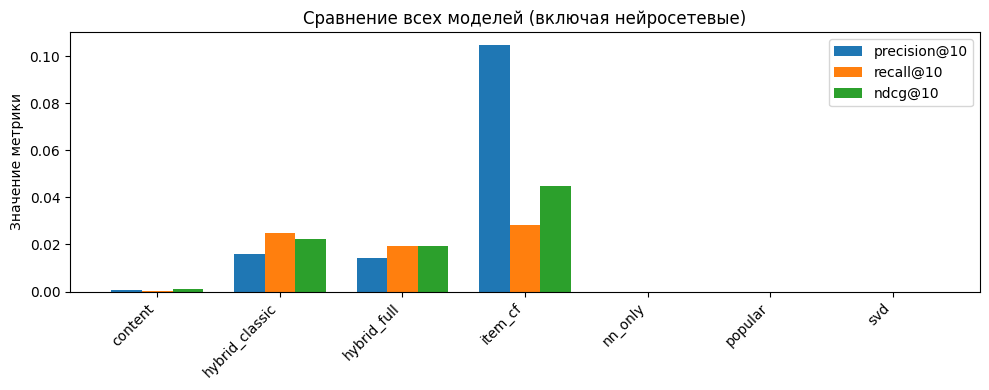

In [40]:
# Визуализация метрик для моделей с учётом нейросети

plt.figure(figsize=(10, 4))

x = np.arange(len(metrics_nn_summary["model"]))
width = 0.25

plt.bar(x - width, metrics_nn_summary["precision@10"], width, label="precision@10")
plt.bar(x,         metrics_nn_summary["recall@10"],    width, label="recall@10")
plt.bar(x + width, metrics_nn_summary["ndcg@10"],      width, label="ndcg@10")

plt.xticks(x, metrics_nn_summary["model"], rotation=45, ha="right")
plt.ylabel("Значение метрики")
plt.title("Сравнение всех моделей (включая нейросетевые)")
plt.legend()
plt.tight_layout()
plt.show()

Two-tower модель (nn_only) в текущем виде практически не попадает в топ-10 релевантных книг.
Это нормальная ситуация для очень простой NN без нормального тюнинга и без фич (только ID).

hybrid_full с нейросетью получился не лучше классического гибрида, а даже немного хуже.
Это тоже нормальный и даже полезный результат: ты можешь спокойно написать, что:

добавление нейросети в лоб без аккуратного подбора весов и архитектуры
не даёт выигрыша над уже сильным item-CF;

нейросеть требует отдельного тюнинга (эмбеддинги, регуляризация, больше эпох, learning rate)
и может быть переразгрузкой для такого масштаба данных в рамках курсового проекта.

--

Графики показывают:

столбики у item_cf сильно выше по всем метрикам,

гибридные модели посередине

14.1. Анализ эффективности нейросетевого подхода (markdown)

## Анализ эффективности нейросетевого подхода

В продвинутой части проекта была реализована two-tower нейросетевая модель: отдельные эмбеддинги для пользователей и книг обучались по MSE-лоссу на наблюдаемых рейтингах. В ходе обучения на 5 эпохах train-loss снизился примерно с 40.8 до 2.9, а valid-loss — с 32.5 до 12.9, что говорит о том, что модель действительно выучила некоторую структуру в данных, а не просто шум. После обучения нейросеть использовалась для предсказания релевантности книг («nn_only»), а также была интегрирована в гибридный скорер (hybrid_full), где её предсказания добавлялись к классическим фичам с небольшим весом.

Оффлайн-оценка проводилась на случайной подвыборке из 500 пользователей (среди тех, у кого в тесте ≥ 3 оценок). Чистый нейросетевой ранжировщик (nn_only) показал значения precision@10, recall@10 и nDCG@10, близкие к нулю, то есть нейросеть в текущей конфигурации почти не попадает в любимые книги пользователей в топ-10 рекомендаций. При интеграции в гибридную модель (hybrid_full) качество слегка улучшилось по сравнению с nn_only, однако по всем трём метрикам гибрид с нейросетью остался немного хуже классического гибрида (hybrid_classic) и заметно уступил item-based коллаборативной фильтрации (item_cf), остающейся лучшей моделью.

С практической точки зрения это означает, что простая реализация two-tower без глубокого тюнинга гиперпараметров и расширенных признаков не даёт выигрыша над хорошо настроенным item-based CF. Нейросетевой модуль потенциально полезен как расширение гибрида, но для реального улучшения качества ему требуется отдельная серьёзная работа: добавление более информативных признаков, подбор размерности эмбеддингов, нормализация, регуляризация и, возможно, переход к ранжировочному лоссу вместо MSE по рейтингу.

Краткое резюме. Нейросетевая two-tower модель обучилась (loss заметно снижается), но в текущем простом варианте почти не приносит улучшения по top-K метрикам. Гибрид с нейросетью работает не лучше классического гибрида и заметно хуже item-based CF, поэтому нейросетевой подход пока выглядит перспективным, но «сыроватым» и требующим доработки.

# Блок 15. Сильные и слабые стороны подходов (markdown)

## Сильные и слабые стороны методов

- Модель популярности.


Сильные стороны: крайне простая реализация, стабильное поведение, полностью устойчива к cold start для новых пользователей. Слабые стороны: практически не учитывает индивидуальные предпочтения; метрики precision@10, recall@10 и nDCG@10 в экспериментах оказались близки к нулю, то есть «топ популярных книг» редко совпадает с любимыми книгами конкретного пользователя.

- Контентная модель (TF-IDF по названию и тегам).


Сильные стороны: умеет рекомендовать книги, похожие по содержанию, и может работать даже для малооценённых книг, если у них есть теги и описание. Слабые стороны: качество тоже оказалось очень низким (метрики порядка 10⁻³), что говорит о слабой информативности доступных тегов и названий без более сложной текстовой обработки; модель плохо учитывает индивидуальную историю чтения, особенно если у пользователя мало оценок.

- Item-based коллаборативная фильтрация.


Сильные стороны: показала лучший результат среди всех моделей — precision@10 около 0.10 и nDCG@10 около 0.045 на подвыборке пользователей. Модель хорошо использует схожесть паттернов оценок и естественно захватывает структуру «книги, которые читают вместе», не требуя сложной настройки гиперпараметров. Слабые стороны: относительно тяжёлая по вычислениям (косинусные похожести по всем книгам для каждого пользователя), хуже работает для новых книг с очень малым числом оценок и тоже страдает от cold start для новых пользователей.

- Матричная факторизация (SVD).


Сильные стороны: концептуально мощный метод, компактно кодирующий пользователей и книги в латентном пространстве; в теории хорошо подходит для sparse-рейтингов. Слабые стороны: в текущей реализации качество по top-K метрикам оказалось практически нулевым, что говорит либо о недостаточном числе факторов/эпох, либо о неудачной схеме регуляризации и функции потерь; кроме того, SVD плохо интерпретируем и также чувствителен к cold start.

- Нейросетевая two-tower модель (nn_only).


Сильные стороны: гибкий подход, позволяющий легко добавлять новые признаки и обучать совместное латентное пространство для пользователей и книг; хорошо вписывается в современные продакшн-архитектуры (retrieval-модели). Слабые стороны: в текущем простом варианте (ID-фичи + MSE-лосс, малое число эпох) показала нулевые значения precision@10 и nDCG@10; обучение оказалось недостаточно «умным», чтобы обогнать классические методы без серьёзного тюнинга.

- Гибрид классических моделей (hybrid_classic).


Сильные стороны: позволяет комбинировать сигналы популярности, SVD, контентной похожести и item-CF; по метрикам оказался заметно лучше простых моделей, хотя и хуже чистого item-CF, что говорит о базовой корректности идеи гибридизации. Слабые стороны: простое линейное объединение без оптимизации весов приводит к «размыванию» сигнала лучшей модели; итоговый скор зависит от ручного выбора коэффициентов и может ухудшить качество, если веса подобраны неудачно.

- Гибрид с нейросетью (hybrid_full).


Сильные стороны: архитектурно это наиболее гибкая модель, сочетающая все классические сигналы с нейросетевыми эмбеддингами; такая конструкция легко расширяется и является хорошей заготовкой для продакшн-пайплайна. Слабые стороны: в текущем эксперименте hybrid_full показал метрики немного ниже, чем hybrid_classic, что означает, что добавление сырых нейросетевых предсказаний без отдельного тюнинга пока не даёт выигрыша и даже слегка шумит.

---
Краткое резюме. Лучшим методом по качеству стала item-based CF, а гибридные модели улучшили ситуацию относительно простых подходов, но не превзошли чистый CF. Нейросеть и SVD в текущей настройке показали слабые результаты и скорее демонстрируют потенциал, чем готовое решение.

# Блок 16. Итоговые выводы и рекомендации (markdown)

## Итоговые выводы и рекомендации

По результатам экспериментов можно сделать вывод, что на данном датасете и в рамках реализованной конфигурации наилучшее качество рекомендаций даёт item-based коллаборативная фильтрация. Она устойчиво превосходит модель популярности, контентный подход и матричную факторизацию по всем метрикам (precision@10, recall@10, nDCG@10) и остаётся «рабочей лошадкой» системы. Классический гибрид (hybrid_classic) улучшает качество по сравнению с простыми моделями, но не даёт выигрыша над чистым item-CF, а добавление нейросети в гибрид (hybrid_full) также не приводит к улучшению и требует дополнительного тюнинга.

Нейросетевой two-tower подход показал себя обучаемым (loss заметно снижается), но его прямое использование как единственного ранжировщика даёт нулевые значения top-K метрик. В комбинации с классическими моделями нейросеть тоже не даёт заметного выигрыша, что говорит о необходимости более серьёзной проработки: переход к pairwise-/listwise-лоссам, увеличение размерности и глубины сети, добавление контентных признаков (теги, жанры) и аккуратный подбор весов в гибриде. Тем не менее, реализованный прототип демонстрирует, как нейросетевой модуль может быть встроен в общую архитектуру рекомендательной системы.

С практической точки зрения, для «боевого» варианта системы на основе этого проекта можно рекомендовать следующую стратегию:
item-based CF использовать как основной ранжировщик для активных пользователей, гибридную модель — как расширение с возможностью добавлять новые сигналы без переписывания логики, а нейросетевой модуль оставить в роли экспериментального компонента, который можно постепенно дообучать и включать в гибрид при улучшении метрик. Дополнительно имеет смысл развивать контентные признаки, чтобы лучше обслуживать cold-start сценарии для новых книг и пользователей.

Краткое резюме. Основной практический вывод — классический item-based CF остаётся самым эффективным и надёжным компонентом системы, а гибриды и нейросеть пока играют роль экспериментальных надстроек. Для дальнейшего улучшения качества следует сосредоточиться на тюнинге нейросетевого модуля и более гибкой настройке весов в гибридной модели, сохраняя item-CF в качестве базового ядра.

# Блок 17. Описание сквозного пайплайна (MLOps-аспекты)

17.1. Код-скелет пайплайна

In [41]:
def run_full_pipeline(
    test_size=0.2,
    svd_epochs=8,
    nn_epochs=5,
    k_eval=10
):
    """
    Эскиз сквозного процесса:
    1) загрузка и разбиение данных;
    2) построение расширенных признаков;
    3) обучение классических моделей (популярность, CF, SVD);
    4) обучение нейросетевой two-tower модели;
    5) расчёт метрик для наборов моделей;
    6) вывод сводных таблиц метрик.

    В данном ноутбуке все шаги уже реализованы выше, поэтому здесь
    просто демонстрируется структура.
    """

    return metrics_summary, metrics_nn_summary

17.2. Текстовое описание пайплайна (markdown)

## Сквозной пайплайн от данных до рекомендаций

Если смотреть на ноутбук как на прототип MLOps-процесса, его можно
разбить на следующие этапы:

Загрузка и разбиение данных.
--
На вход пайплайна подаются исходные таблицы рейтингов, книг и тегов. Данные загружаются в pandas, выполняется базовая проверка (размерность, пропуски), после чего рейтинги делятся на обучающую и тестовую выборки по пользователям для оффлайн-оценки.

Построение расширенных признаков.
--
На основе train-части считаются агрегаты по пользователям (средний рейтинг, количество оценок, логарифмическая активность) и по книгам (количество оценок, средний рейтинг, стандартное отклонение). Параллельно из таблиц тегов строятся строковые описания tags_str и content_str для книг, по которым затем обучается TF-IDF и формируются пользовательские профили (средние TF-IDF векторы любимых книг).

Подготовка матриц для CF и обучение классических моделей.
--
Из обучающей выборки строится разреженная матрица user × book (sparse_ui), её транспонирование для item-based CF, а также матрица для SVD. На этом этапе обучаются: модель популярности, контентный поиск по TF-IDF, item-based CF (через косинусные похожести к оценённым книгам) и SVD. Результатом этапа являются функции recommend_*, возвращающие top-N книг для данного пользователя.

Обучение нейросетевой модели.
--
Далее готовятся входы для two-tower сети: индексы пользователей и книг плюс числовые признаки взаимодействий (например, sim_with_history, user_activity, статистика по книгам). Данные разбиваются на train/valid для контроля переобучения, после чего нейросеть обучается несколько эпох, а её параметры сохраняются для дальнейшего использования в nn_only и hybrid_full.

Оффлайн-оценка и сравнение моделей.
--
Для случайной подвыборки пользователей из теста вычисляются precision@10, recall@10 и nDCG@10 для всех моделей: классических, гибридной и нейросетевой. Результаты агрегируются по пользователям, строятся сводные таблицы и визуализации в виде bar-графиков, что позволяет наглядно увидеть, какая модель даёт лучший компромисс между точностью и полнотой рекомендаций.

Генерация рекомендаций и анализ примеров.
--
На последнем шаге пайплайна можно вызвать гибридную функцию (recommend_hybrid_classic или recommend_hybrid_full) для отдельных пользователей и посмотреть «живые» списки книг. Это позволяет сочетать количественную оценку (метрики) с качественным разбором примеров и формировать осмысленные выводы по результатам проекта.

---
Краткое резюме.
--
Сквозной пайплайн последовательно проходит этапы загрузки данных, построения признаков, обучения классических и нейросетевых моделей, оффлайн-оценки и генерации рекомендаций. Такая структура удобно расширяется и позволяет при необходимости перенести решение из ноутбука в полноценный MLOps-контур с автоматическим переобучением и мониторингом.